In [1]:
import glmnet_python as glm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

In [24]:
from sklearn.linear_model import Ridge
def ridge_regression(data, new_data, lag_Y, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(new_data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        i = range(len(new_data['y']))
        plt.plot(i,y_pred)
        plt.plot(i,lag_Y)
        plt.plot(i,new_data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-new_data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

In [3]:
from sklearn.linear_model import Lasso
# data for training, new_data for predicting
def lasso_regression(data, new_data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(new_data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        i = range(len(new_data['y']))
        plt.plot(i,y_pred)
        plt.plot(i,new_data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-new_data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [4]:
from sklearn.linear_model import ElasticNet
def ElasticNet_regression(data, new_data, ratio, predictors, alpha, models_to_plot={}):
    #Fit the model
    ElasticNetreg = ElasticNet(alpha=alpha,l1_ratio=ratio, fit_intercept=True, normalize=True, max_iter=1e5)
    ElasticNetreg.fit(data[predictors],data['y'])
    y_pred = ElasticNetreg.predict(new_data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        i = range(len(new_data['y']))
        plt.plot(i,y_pred)
        plt.plot(i,new_data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-new_data['y'])**2)
    ret = [rss]
    ret.extend([ElasticNetreg.intercept_])
    ret.extend(ElasticNetreg.coef_)
    return ret

In [31]:
# extract data of a link(31day*240min)
i = 0
link_name = "link_travel_time\link_" + str(i) + ".csv"
Data = pd.read_csv(link_name)
Data = Data.values[:,1]
#print(len(Data))

7439


In [43]:
def mean_filt(data, window):
    L = len(data)
    result = np.zeros(len(data))
    for i in range(L):
        left = max(0,i-window)
        right = min(L,i+window+1)
        result[i] = sum(data[left:right]) / (right - left)
    return result

In [45]:
Data = mean_filt(Data,2)

In [79]:
# dependent variable(traning example)
predicting = 29 # the day to predict
Y = [] # training examples
new_Y = [] # the real value of prediction
lag_Y = [] # pure lag without prediction
step_ahead = 10 #step to predict
t_day = 1 # number of days for training

# model of 7:00-8:00,7/21-7/30
offset = 120 # begin time
daily = 240 # number of points/day
m_period = 20 # time period within a model
for i in range(m_period):
    new_Y.append(Data[predicting*daily+offset+i])
    lag_Y.append(Data[predicting*daily+offset+i-step_ahead])
    for training in range(predicting - t_day,predicting):#predict
    #for training in range(predicting,predicting+1):#fit
        Y.append(Data[training*daily+offset+i])   
#print(Y)

In [80]:
# independent variable(traning example)
X = [] # training examples
new_X = [] # for prediction

# predictor parameters      
pre_day = 7 #the 6-day before,[time-q,time+q] 
q = 15
pre_week = 3 #the same 2 date before,[time-q,time+q]
p = 30 #before in the same day,[time-p,time-1]

for i in range(m_period):
    # to predict
    new_predictor = []
    # predictors: the 6-day before at the same time
    for j in range(1,pre_day):
        for k in range(-q,q):
            new_predictor.append(Data[daily*(predicting-j)+i+k])
    # predictors: the same 2 date before at the same time
    for j in range(1,pre_week):
        for k in range(-q,q):
            new_predictor.append(Data[daily*(predicting-j*7)+i+k])
    # predictors: before in the same day
    for j in range(step_ahead,p+step_ahead):
        new_predictor.append(Data[daily*predicting+i-j])
    new_X.append(new_predictor)
    
    #training model
    for training in range(predicting - t_day,predicting):#predict
    #for training in range(predicting,predicting+1):#fit
        predictor = []
        # predictors: the 6-day before at the same time
        for j in range(1,pre_day):
            for k in range(-q,q):
                predictor.append(Data[daily*(training-j)+i+k])
        # predictors: the same 2 date before at the same time
        for j in range(1,pre_week):
            for k in range(-q,q):
                predictor.append(Data[daily*(training-j*7)+i+k])
        # predictors: before in the same day
        for j in range(step_ahead,p+step_ahead):
            predictor.append(Data[daily*training+i-j])
        X.append(predictor)
#print(X[0],X[1])

In [81]:
# transform to dataframe
X = np.array(X).transpose()
new_X = np.array(new_X).transpose()
dataset = pd.DataFrame()
new_dataset = pd.DataFrame()
dataset['y'] = pd.Series(Y)
new_dataset['y'] = pd.Series(new_Y)
for i in range(len(X)):
    colname = 'x_%d'%(i+1)
    x = pd.Series(X[i])
    new_x = pd.Series(new_X[i])
    dataset[colname] = x
    new_dataset[colname] = new_x
#print(dataset.head())

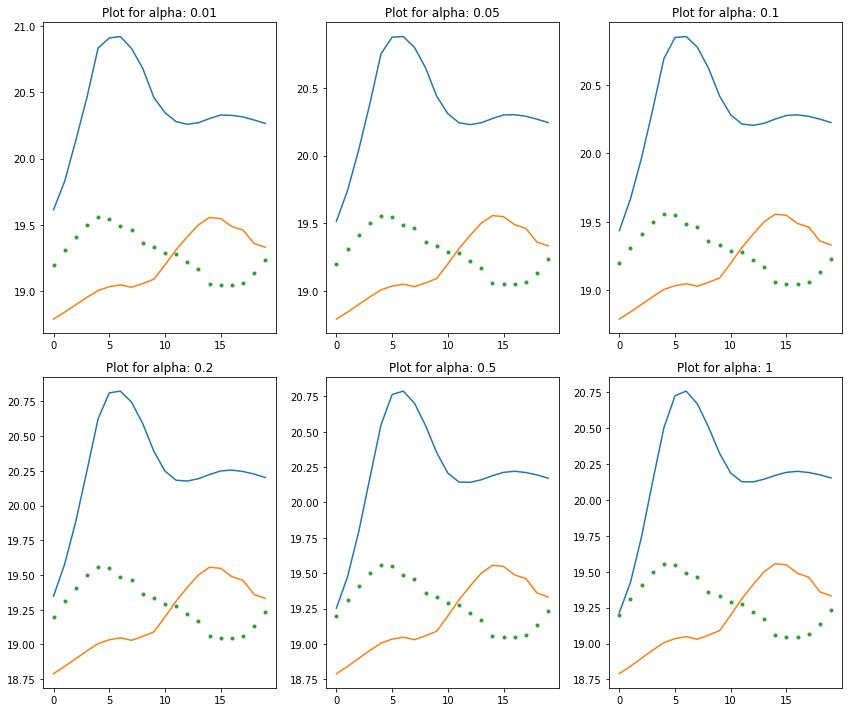

In [82]:
# test of ridge 

#Initialize predictors
predictors = []
predictors.extend(['x_%d'%(i+1) for i in range(len(X))])

#Define the alpha values to test
#alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
alpha_ridge = [0.01, 0.05, 0.1, 0.2, 0.5, 1,]

#Define the models to plot
models_to_plot = {0.01:231, 0.05:232, 0.1:233, 0.2:234, 0.5:235, 1:236}

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%(i+1) for i in range(len(X))]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(len(alpha_ridge))]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

#Iterate over the 10 alpha values:
for i in range(len(alpha_ridge)):
    coef_matrix_ridge.iloc[i,] = ridge_regression(dataset, new_dataset, lag_Y, predictors, alpha_ridge[i], models_to_plot)
plt.show()

In [20]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
#coef_matrix_ridge.to_csv('ridge.csv')

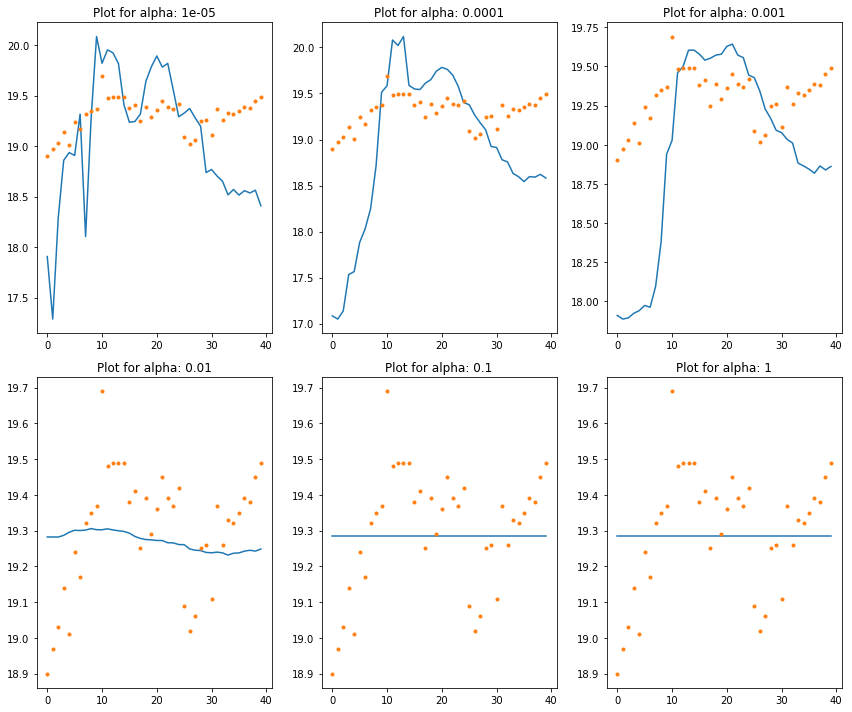

In [21]:
# test of lasso regression

#Initialize predictors
predictors=[]
predictors.extend(['x_%d'%(i+1) for i in range(len(X))])

#Define the alpha values to test
#alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
alpha_lasso = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%(i+1) for i in range(len(X))]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-5:231, 1e-4:232,1e-3:233, 1e-2:234, 1e-1:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(dataset, new_dataset, predictors, alpha_lasso[i], models_to_plot)
plt.show()


In [22]:
#coef_matrix_lasso.to_csv('lasso.csv')
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-05      30
alpha_0.0001    121
alpha_0.001     208
alpha_0.01      258
alpha_0.1       260
alpha_1         260
dtype: int64

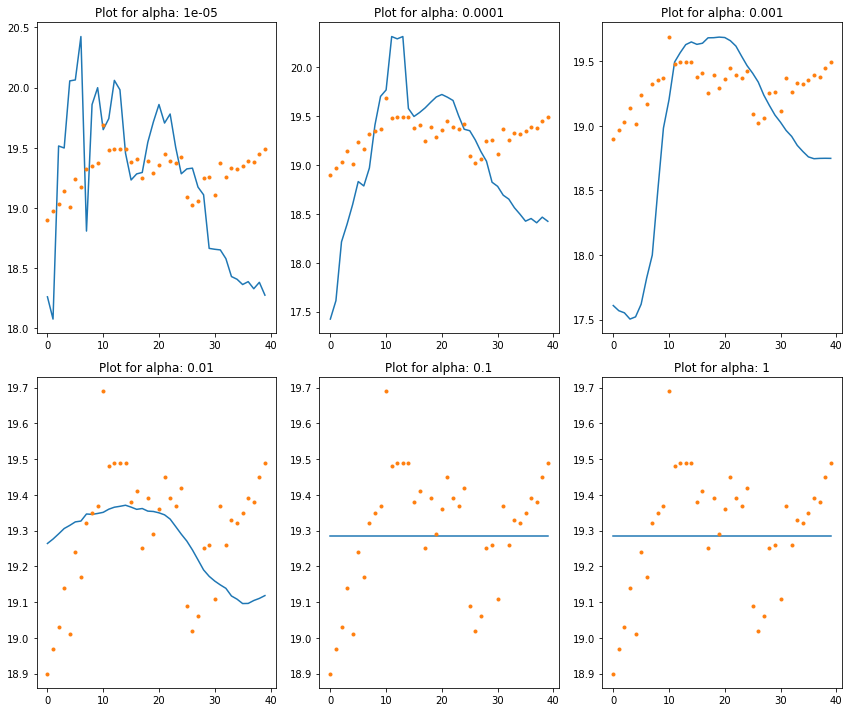

In [14]:
# test of ElasticNet regression

#Initialize predictors
predictors=[]
predictors.extend(['x_%d'%(i+1) for i in range(len(X))])

#Define the alpha values to test
#alpha_ElasticNet = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
alpha_ElasticNet = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%(i+1) for i in range(len(X))]
ind = ['alpha_%.2g'%alpha_ElasticNet[i] for i in range(len(alpha_ElasticNet))]
coef_matrix_ElasticNet = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-5:231, 1e-4:232,1e-3:233, 1e-2:234, 1e-1:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(len(alpha_ElasticNet)):
    coef_matrix_ElasticNet.iloc[i,] = ElasticNet_regression(dataset, new_dataset, 0.5, predictors, alpha_ElasticNet[i], models_to_plot)
plt.show()

In [15]:
#coef_matrix_ElasticNet.to_csv('ElasticNet.csv')
coef_matrix_ElasticNet.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-05      18
alpha_0.0001     79
alpha_0.001     147
alpha_0.01      222
alpha_0.1       269
alpha_1         269
dtype: int64

In [ ]:
# rss of pure lag(static real-time data)
rss = sum((y_pred-new_data['y'])**2)